<a href="https://colab.research.google.com/github/nandinib1999/handwritten-text-recognition/blob/main/Handwritten_Text_Recognition_IAM_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [12]:
!git clone "https://github.com/nandinib1999/handwritten-text-recognition"

Cloning into 'handwritten-text-recognition'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 42 (delta 14), reused 12 (delta 1), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [13]:
cd "/content/handwritten-text-recognition"

/content/handwritten-text-recognition


In [14]:
!mkdir "dataset"

In [15]:
import tarfile
tf = tarfile.open("/content/drive/MyDrive/words.tar")
tf.extractall("dataset")

In [16]:
with open('parser.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents]

In [17]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [18]:
images = []
labels = []

In [23]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [24]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

## Generate train & validation set

In [25]:
for indx, line in enumerate(lines):
  if indx > 10000:
    break
  splits = line.split(' ')
  status = splits[1]
  
  if status == 'ok':
    word_id = splits[0]
    word = "".join(splits[8:])
    
    splits_id = word_id.split('-')
    filepath = 'dataset/{}/{}-{}/{}.png'.format(splits_id[0], 
                                              splits_id[0], 
                                              splits_id[1], 
                                              word_id)
    
    # process image
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
      img = process_image(img)
      label = encode_to_labels(word)

      if indx % 10 == 0:
          valid_images.append(img)
          valid_labels.append(label)
          valid_input_length.append(31)
          valid_label_length.append(len(word))
          valid_original_text.append(word)
      else:
          train_images.append(img)
          train_labels.append(label)
          train_input_length.append(31)
          train_label_length.append(len(word))
          train_original_text.append(word)
      
      if len(word) > max_label_len:
          max_label_len = len(word)

In [26]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [27]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

## Converts to Numpy array

In [28]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [29]:
train_images.shape

(7850, 32, 128, 1)

## Build Model
Convolutional Recurrent Neural Network 

In [30]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [31]:
act_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 32, 256)        5900

In [32]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [33]:
batch_size = 8
epochs = 60
e = str(epochs)
optimizer_name = 'adam'

In [34]:
import time
from tensorflow.keras.callbacks import Callback
from datetime import datetime

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []
    
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
        self.train_epoch_times.append(cur_epoch_time )
        # cur_epoch_time = datetime.strptime(str(cur_epoch_time), "%H:%M:%S.%f").strftime('%H:%M:%S')
        self.train_epoch_times.append(cur_epoch_time)
        print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))
    
    ## functions used below are for recording validation times
    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        # cur_test_time = datetime.strptime(str(cur_test_time), "%H:%M:%S.%f").strftime('%H:%M:%S')
        print(" ;validation took {0} minutes.".format(cur_test_time))

In [35]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="word_model-{}o-{}e.hdf5".format(optimizer_name, str(epochs))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
epoch_times = EpochTimeHistory()
callbacks_list = [checkpoint, earlystop, epoch_times]

In [36]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1, callbacks=callbacks_list)

Epoch 1/60
982/982 [==============================] - 91s 34ms/step - loss: 16.2285 - accuracy: 0.0034 - val_loss: 13.5430 - val_accuracy: 0.0023

Epoch 00001: val_loss improved from inf to 13.54296, saving model to word_model-adamo-60e.hdf5
 ;epoch 1 took 1.5217 minutes.
Epoch 2/60
982/982 [==============================] - 29s 29ms/step - loss: 12.0557 - accuracy: 0.0483 - val_loss: 11.0099 - val_accuracy: 0.0856

Epoch 00002: val_loss improved from 13.54296 to 11.00988, saving model to word_model-adamo-60e.hdf5
 ;epoch 2 took 0.482 minutes.
Epoch 3/60
982/982 [==============================] - 28s 29ms/step - loss: 10.3461 - accuracy: 0.0763 - val_loss: 9.5521 - val_accuracy: 0.0890

Epoch 00003: val_loss improved from 11.00988 to 9.55209, saving model to word_model-adamo-60e.hdf5
 ;epoch 3 took 0.479 minutes.
Epoch 4/60
982/982 [==============================] - 29s 29ms/step - loss: 8.9601 - accuracy: 0.1167 - val_loss: 9.0496 - val_accuracy: 0.1358

Epoch 00004: val_loss improved

## Evaluate Model Performance

original_text =   week-end
predicted text =  weete-end


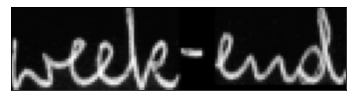



original_text =   "
predicted text =  "


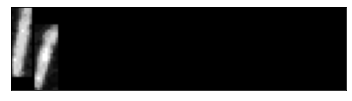



original_text =   Roy's
predicted text =  Ry's


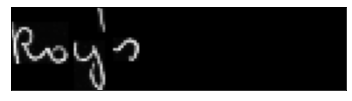



original_text =   the
predicted text =  the


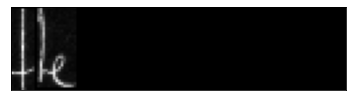



original_text =   because
predicted text =  hacaue


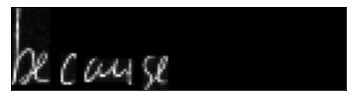



original_text =   were
predicted text =  woe


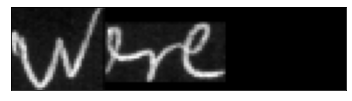



original_text =   by
predicted text =  br


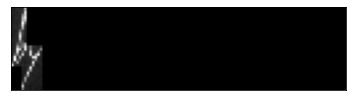



original_text =   talks
predicted text =  tillhs


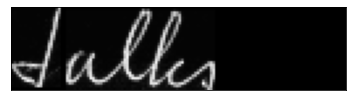



original_text =   today
predicted text =  selany


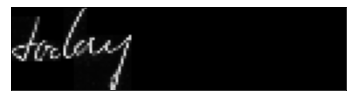



original_text =   Minister
predicted text =  Miitar


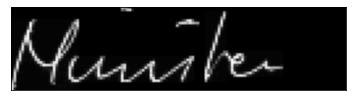



original_text =   will
predicted text =  wll


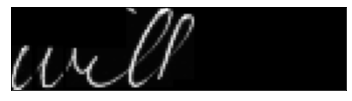



original_text =   Government
predicted text =  Grvernment


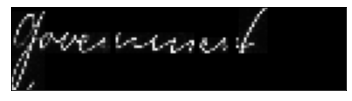



original_text =   Lancaster
predicted text =  Concater


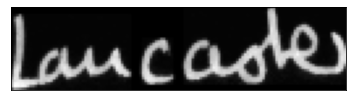



original_text =   the
predicted text =  the


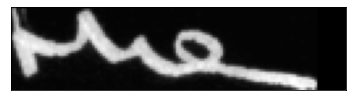



original_text =   It
predicted text =  It


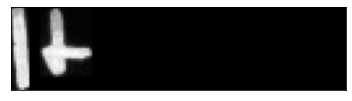



original_text =   the
predicted text =  the


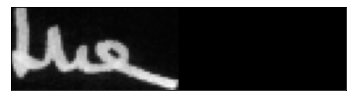



original_text =   Weaver
predicted text =  Weaver


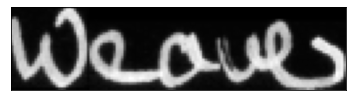



original_text =   be
predicted text =  "e


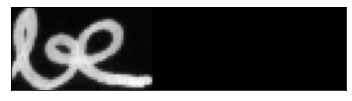



original_text =   and
predicted text =  and


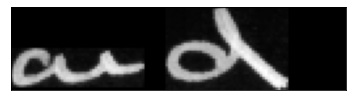



original_text =   will
predicted text =  wit


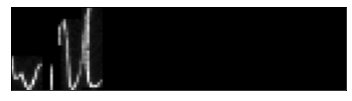



original_text =   of
predicted text =  of


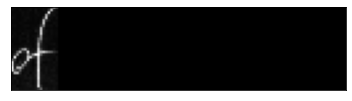



original_text =   aroused
predicted text =  cnnad


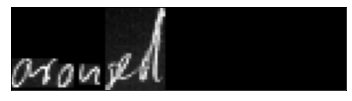



original_text =   South
predicted text =  Bact


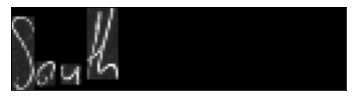



original_text =   York
predicted text =  Rak


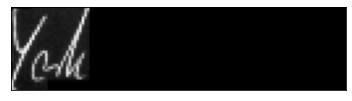



original_text =   there
predicted text =  the


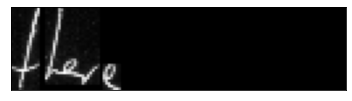



original_text =   projects
predicted text =  picts


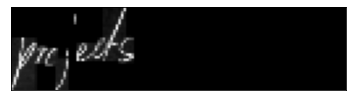



original_text =   opposition
predicted text =  apposition


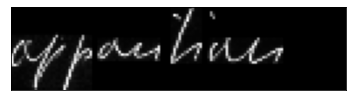



original_text =   Washington
predicted text =  waslighn


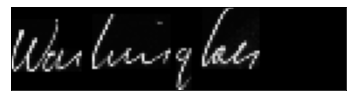



original_text =   The
predicted text =  The


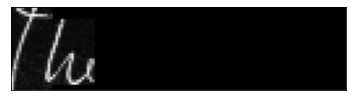



original_text =   Southern
predicted text =  lubhains


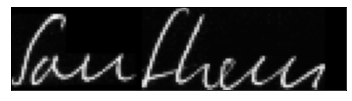



original_text =   today
predicted text =  talay


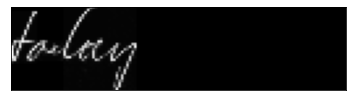



original_text =   Robertson
predicted text =  Lbauboun


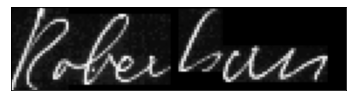



original_text =   Kennedy
predicted text =  Kennling


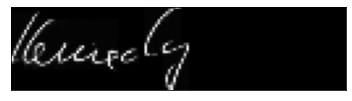



original_text =   the
predicted text =  the


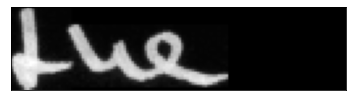



original_text =   current
predicted text =  ouvrent


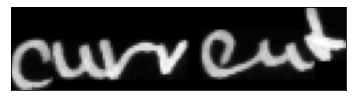



original_text =   .
predicted text =  .


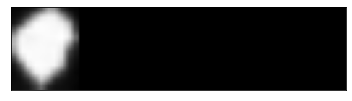



original_text =   another
predicted text =  anther


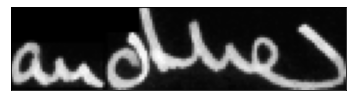



original_text =   met
predicted text =  met


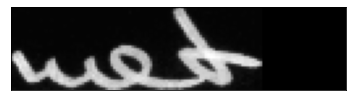



original_text =   Mr.
predicted text =  Mr.


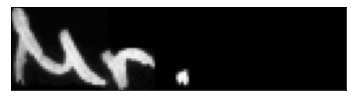



original_text =   television
predicted text =  telesision


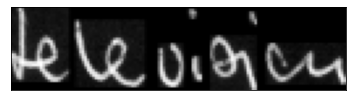



original_text =   Weaver
predicted text =  Weaver


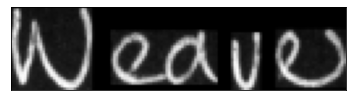



original_text =   Committee
predicted text =  Caumitee


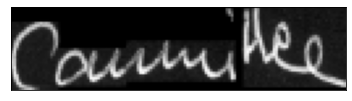



original_text =   Willis
predicted text =  Willis


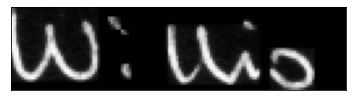



original_text =   he
predicted text =  be


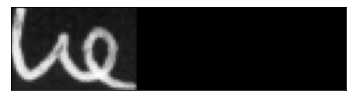



original_text =   had
predicted text =  had


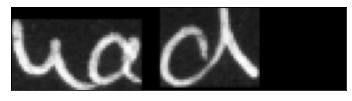



original_text =   by
predicted text =  b


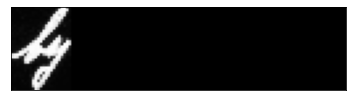



original_text =   to
predicted text =  "


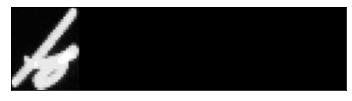



original_text =   perform
predicted text =  pot


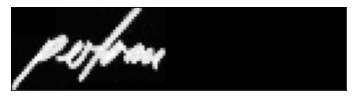



original_text =   Robertson's
predicted text =  Rerts's


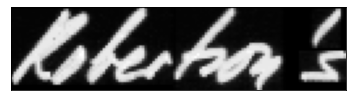



original_text =   can
predicted text =  cos


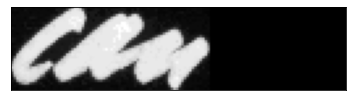

In [38]:
prediction = act_model.predict(valid_images[150:200])
decoded = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]
out = K.get_value(decoded)

for i, x in enumerate(out):
  pred_str = ""
  for p in x:
    if int(p) != -1:
      pred_str += char_list[int(p)]
  print("original_text =  ", valid_original_text[150+i])
  print("predicted text = ", pred_str)
  plt.imshow(valid_images[150+i].reshape(32,128), cmap=plt.cm.gray)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print('\n')

##### Given the small amount of data that we used for training the model - Only 10000 images from such huge dataset, I think the model performance is quite good.

### **Ideas to improve model performance**

- Add more training data
- Add attention layer in the model
- Add GRU layer in the model

In [39]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'g')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

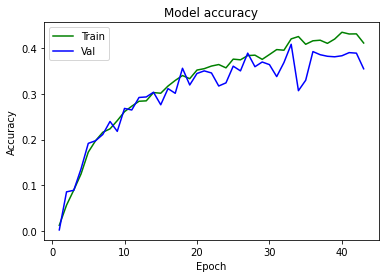

In [42]:
plotgraph(epochs, acc, val_acc)